**Load and Preprocess the Dataset**

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load your dataset
data = pd.read_csv('heart.csv')

# Preprocess the dataset (if necessary)
# Example: Standardize the numerical features
scaler = StandardScaler()
numerical_columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Split data into features (X) and target (y)
X = data.drop('target', axis=1)
y = data['target']

**CTGAN Training and Synthetic Data Generation**



In [ ]:
!pip install ctgan
import pandas as pd
from ctgan import CTGAN
import pickle
import os

# Load the dataset
data = pd.read_csv('heart.csv')

# Identify categorical columns
categorical_columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

# Initialize and train CTGAN
ctgan = CTGAN(epochs=1000)  # Adjust epochs as needed
ctgan.fit(data, categorical_columns)

# Save the trained model
model_filename = 'ctgan_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(ctgan, model_file)
print(f"Model saved as '{model_filename}'")

# Load the saved model
with open(model_filename, 'rb') as model_file:
    loaded_ctgan = pickle.load(model_file)

# Generate synthetic data
num_samples = len(data)
synthetic_data = loaded_ctgan.sample(num_samples)

# Post-process synthetic data to match the original feature ranges
synthetic_data['age'] = synthetic_data['age'].clip(29, 77)
synthetic_data['sex'] = synthetic_data['sex'].round().clip(0, 1)
synthetic_data['cp'] = synthetic_data['cp'].round().clip(0, 3)  # chest pain type
synthetic_data['trestbps'] = synthetic_data['trestbps'].clip(94, 200)  # resting blood pressure
synthetic_data['chol'] = synthetic_data['chol'].clip(126, 564)  # serum cholesterol
synthetic_data['fbs'] = synthetic_data['fbs'].round().clip(0, 1)  # fasting blood sugar
synthetic_data['restecg'] = synthetic_data['restecg'].round().clip(0, 2)  # resting ECG
synthetic_data['thalach'] = synthetic_data['thalach'].clip(71, 202)  # max heart rate achieved
synthetic_data['exang'] = synthetic_data['exang'].round().clip(0, 1)  # exercise induced angina
synthetic_data['oldpeak'] = synthetic_data['oldpeak'].clip(0, 6.2)  # ST depression
synthetic_data['slope'] = synthetic_data['slope'].round().clip(0, 2)  # slope of the peak ST segment (categorical: 0, 1, 2)
synthetic_data['ca'] = synthetic_data['ca'].round().clip(0, 4)  # number of major vessels
synthetic_data['thal'] = synthetic_data['thal'].round().clip(0, 3)  # thalassemia

# Ensure the target variable is binary
synthetic_data['target'] = synthetic_data['target'].round().clip(0, 1)

# Save synthetic data to CSV
synthetic_data.to_csv('synthetic_data_ctgan.csv', index=False)
print("Synthetic data saved as 'synthetic_data_ctgan.csv'")

# Verify the file was created
if os.path.exists('synthetic_data_ctgan.csv'):
    print(f"File 'synthetic_data_ctgan.csv' created. Size: {os.path.getsize('synthetic_data_ctgan.csv')} bytes")
else:
    print("File 'synthetic_data_ctgan.csv' was not created")

# Basic comparison of real and synthetic data
print("\nReal Data Info:")
print(data.info())
print("\nSynthetic Data Info:")
print(synthetic_data.info())

# Compare basic statistics
print("\nReal Data Description:")
print(data.describe())
print("\nSynthetic Data Description:")
print(synthetic_data.describe())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 78.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Model saved as 'ctgan_model.pkl'
Synthetic data saved as 'synthetic_data_ctgan.csv'
File 'synthetic_data_ctgan.csv' created. Size: 37968 bytes

Real Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
None

Synthetic Data Info:
<class 'pandas.core.frame.Dat

**VAE** Training and Synthetic Data Generation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load and preprocess the data
data = pd.read_csv('heart.csv')

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# VAE parameters
original_dim = scaled_data.shape[1]
intermediate_dim = 64
latent_dim = 32
epochs = 1000
batch_size = 32

class VAE(keras.Model):
    def __init__(self, original_dim, intermediate_dim, latent_dim):
        super(VAE, self).__init__()
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(original_dim,)),
            layers.Dense(intermediate_dim, activation="relu"),
            layers.Dense(latent_dim * 2)
        ])

        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(intermediate_dim, activation="relu"),
            layers.Dense(original_dim)
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * logvar) * epsilon

    def decode(self, z):
        return self.decoder(z)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z)
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mean, logvar = self.encode(data)
            z = self.reparameterize(mean, logvar)
            reconstructed = self.decode(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstructed), axis=-1
                )
            )
            kl_loss = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=-1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Dummy loss function (won't be used, but required by Keras)
def dummy_loss(y_true, y_pred):
    return tf.reduce_mean(y_pred)

# Create and compile the model
vae = VAE(original_dim, intermediate_dim, latent_dim)
vae.compile(optimizer=keras.optimizers.Adam(), loss=dummy_loss)

# Train the model
history = vae.fit(scaled_data, scaled_data, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Generate synthetic data
latent_samples = tf.random.normal(shape=(len(data), latent_dim))
synthetic_data_scaled = vae.decode(latent_samples)

# Convert to numpy and inverse transform
synthetic_data = scaler.inverse_transform(synthetic_data_scaled.numpy())

# Post-process synthetic data to match the original feature ranges
synthetic_df = pd.DataFrame(synthetic_data, columns=data.columns)

# Clip and round continuous and categorical features
synthetic_df['age'] = synthetic_df['age'].clip(29, 77)
synthetic_df['sex'] = synthetic_df['sex'].round().clip(0, 1)
synthetic_df['cp'] = synthetic_df['cp'].round().clip(0, 3)  # chest pain type
synthetic_df['trestbps'] = synthetic_df['trestbps'].clip(94, 200)  # resting blood pressure
synthetic_df['chol'] = synthetic_df['chol'].clip(126, 564)  # serum cholesterol
synthetic_df['fbs'] = synthetic_df['fbs'].round().clip(0, 1)  # fasting blood sugar
synthetic_df['restecg'] = synthetic_df['restecg'].round().clip(0, 2)  # resting ECG
synthetic_df['thalach'] = synthetic_df['thalach'].clip(71, 202)  # max heart rate achieved
synthetic_df['exang'] = synthetic_df['exang'].round().clip(0, 1)  # exercise induced angina
synthetic_df['oldpeak'] = synthetic_df['oldpeak'].clip(0, 6.2)  # ST depression
synthetic_df['slope'] = synthetic_df['slope'].round().clip(0, 2)  # slope of the peak ST segment
synthetic_df['ca'] = synthetic_df['ca'].round().clip(0, 4)  # number of major vessels
synthetic_df['thal'] = synthetic_df['thal'].round().clip(0, 3)  # thalassemia

# Ensure the target variable is binary
synthetic_df['target'] = synthetic_df['target'].round().clip(0, 1)

# Save synthetic data
synthetic_df.to_csv('synthetic_data_vae.csv', index=False)
print("Synthetic data saved as 'synthetic_data_vae.csv'")

# Basic comparison
print("\nReal Data Info:")
print(data.info())
print("\nSynthetic Data Info:")
print(synthetic_df.info())

print("\nReal Data Description:")
print(data.describe())
print("\nSynthetic Data Description:")
print(synthetic_df.describe())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - kl_loss: 3.3413 - loss: 46.2219 - reconstruction_loss: 42.8807 - val_loss: -0.0092
Epoch 2/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - kl_loss: 3.3202 - loss: 35.9341 - reconstruction_loss: 32.6139 - val_loss: -0.0046
Epoch 3/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.5826 - loss: 32.2568 - reconstruction_loss: 28.6741 - val_loss: 0.0191
Epoch 4/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 4.0318 - loss: 29.5308 - reconstruction_loss: 25.4991 - val_loss: 0.0015
Epoch 5/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 4.4992 - loss: 27.8888 - reconstruction_loss: 23.3896 - val_loss: 0.0129
Epoch 6/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.0212 - loss: 26.6065 - reconstruction_loss: 21.5853 - val_loss: 5.4260e-04
Epoch 7/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.4569 - loss: 25.4826 - reconstruction_loss: 20.0256 - val_loss: 0.0035
Epoch 8/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 

### **Table Diffusion Training and Synthetic Data Generation**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Load and preprocess the data
data = pd.read_csv('heart.csv')
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data).astype(np.float32)

# Model parameters
input_dim = scaled_data.shape[1]
hidden_dim = 128
num_steps = 1000
beta_start = 1e-4
beta_end = 0.02

# Calculate beta schedule
betas = np.linspace(beta_start, beta_end, num_steps).astype(np.float32)  # Ensure float32
alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas).astype(np.float32)  # Ensure float32

class TableDiffusion(keras.Model):
    def __init__(self, input_dim, hidden_dim):
        super(TableDiffusion, self).__init__()
        self.model = keras.Sequential([
            keras.layers.Dense(hidden_dim, activation='relu', input_shape=(input_dim + 1,)),
            keras.layers.Dense(hidden_dim, activation='relu'),
            keras.layers.Dense(input_dim)
        ])

    def call(self, x, t):
        batch_size = tf.shape(x)[0]
        t_emb = tf.sin(t[:, tf.newaxis] * np.pi / 2)
        x_input = tf.concat([x, t_emb], axis=-1)
        return self.model(x_input)

def diffusion_loss(model, x_0, t):
    noise = tf.random.normal(shape=tf.shape(x_0), dtype=tf.float32)
    alpha_cumprod_t = tf.gather(alphas_cumprod, t)
    alpha_cumprod_t = tf.reshape(alpha_cumprod_t, (-1, 1))

    mean = tf.sqrt(alpha_cumprod_t) * x_0
    std = tf.sqrt(1.0 - alpha_cumprod_t)
    x_t = mean + std * noise

    predicted_noise = model(x_t, tf.cast(t, tf.float32))
    return tf.reduce_mean(tf.square(noise - predicted_noise))

# Create and compile the model
model = TableDiffusion(input_dim, hidden_dim)
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

@tf.function
def train_step(x):
    t = tf.random.uniform(shape=(tf.shape(x)[0],), minval=0, maxval=num_steps, dtype=tf.int32)
    with tf.GradientTape() as tape:
        loss = diffusion_loss(model, x, t)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training loop
batch_size = 32
epochs = 100
n_samples = scaled_data.shape[0]

for epoch in range(epochs):
    for i in range(0, n_samples, batch_size):
        batch = scaled_data[i:i+batch_size]
        loss = train_step(batch)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.4f}")

# Generate synthetic data
def sample(model, n_samples):
    x = tf.random.normal(shape=(n_samples, input_dim), dtype=tf.float32)
    for t in reversed(range(num_steps)):
        t_tensor = tf.ones((n_samples,), dtype=tf.int32) * t
        predicted_noise = model(x, tf.cast(t_tensor, tf.float32))
        alpha_t = tf.convert_to_tensor(alphas[t], dtype=tf.float32)  # Ensure float32
        alpha_t_bar = tf.convert_to_tensor(alphas_cumprod[t], dtype=tf.float32)  # Ensure float32

        if t > 0:
            noise = tf.random.normal(shape=tf.shape(x), dtype=tf.float32)
        else:
            noise = tf.zeros_like(x)

        x = (1 / tf.sqrt(alpha_t)) * (x - (1 - alpha_t) / tf.sqrt(1 - alpha_t_bar) * predicted_noise) + tf.sqrt(1 - alpha_t) * noise
    return x

# Generate synthetic samples
synthetic_scaled = sample(model, n_samples).numpy()

# Inverse transform to get the original scale
synthetic_data = scaler.inverse_transform(synthetic_scaled)

# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=data.columns)

# Post-process synthetic data to match the original feature ranges
synthetic_df['age'] = synthetic_df['age'].clip(29, 77)
synthetic_df['sex'] = synthetic_df['sex'].round().clip(0, 1)
synthetic_df['cp'] = synthetic_df['cp'].round().clip(0, 3)  # chest pain type
synthetic_df['trestbps'] = synthetic_df['trestbps'].clip(94, 200)  # resting blood pressure
synthetic_df['chol'] = synthetic_df['chol'].clip(126, 564)  # serum cholesterol
synthetic_df['fbs'] = synthetic_df['fbs'].round().clip(0, 1)  # fasting blood sugar
synthetic_df['restecg'] = synthetic_df['restecg'].round().clip(0, 2)  # resting ECG
synthetic_df['thalach'] = synthetic_df['thalach'].clip(71, 202)  # max heart rate achieved
synthetic_df['exang'] = synthetic_df['exang'].round().clip(0, 1)  # exercise induced angina
synthetic_df['oldpeak'] = synthetic_df['oldpeak'].clip(0, 6.2)  # ST depression
synthetic_df['slope'] = synthetic_df['slope'].round().clip(0, 2)  # slope of the peak ST segment
synthetic_df['ca'] = synthetic_df['ca'].round().clip(0, 4)  # number of major vessels
synthetic_df['thal'] = synthetic_df['thal'].round().clip(0, 3)  # thalassemia

# Ensure the target variable is binary
synthetic_df['target'] = synthetic_df['target'].round().clip(0, 1)

# Save synthetic data
synthetic_df.to_csv('synthetic_data_diffusion.csv', index=False)
print("Synthetic data saved as 'synthetic_data_diffusion.csv'")

# Basic comparison
print("\nReal Data Info:")
print(data.info())
print("\nSynthetic Data Info:")
print(synthetic_df.info())

print("\nReal Data Description:")
print(data.describe())
print("\nSynthetic Data Description:")
print(synthetic_df.describe())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 0, Loss: 1.0441
Epoch 10, Loss: 0.4856
Epoch 20, Loss: 0.4631
Epoch 30, Loss: 0.2261
Epoch 40, Loss: 1.2511
Epoch 50, Loss: 0.4345
Epoch 60, Loss: 0.5786
Epoch 70, Loss: 0.1593
Epoch 80, Loss: 0.2684
Epoch 90, Loss: 0.7241
Synthetic data saved as 'synthetic_data_diffusion.csv'

Real Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  ta

## **Analysing of the generated and original dataset**

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 820.8/820.8 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 123.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 116.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 38.5 MB/s eta 0:00:00
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.7.1
    Uninstalling traitlets-5.7.1:
      Succe

[0 1]


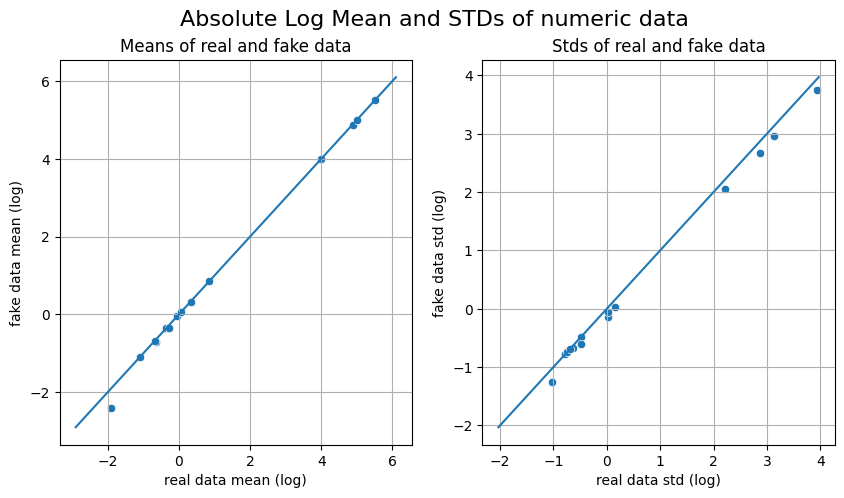

Error while plotting column age


TypeError: cdf() got an unexpected keyword argument 'local_ax'

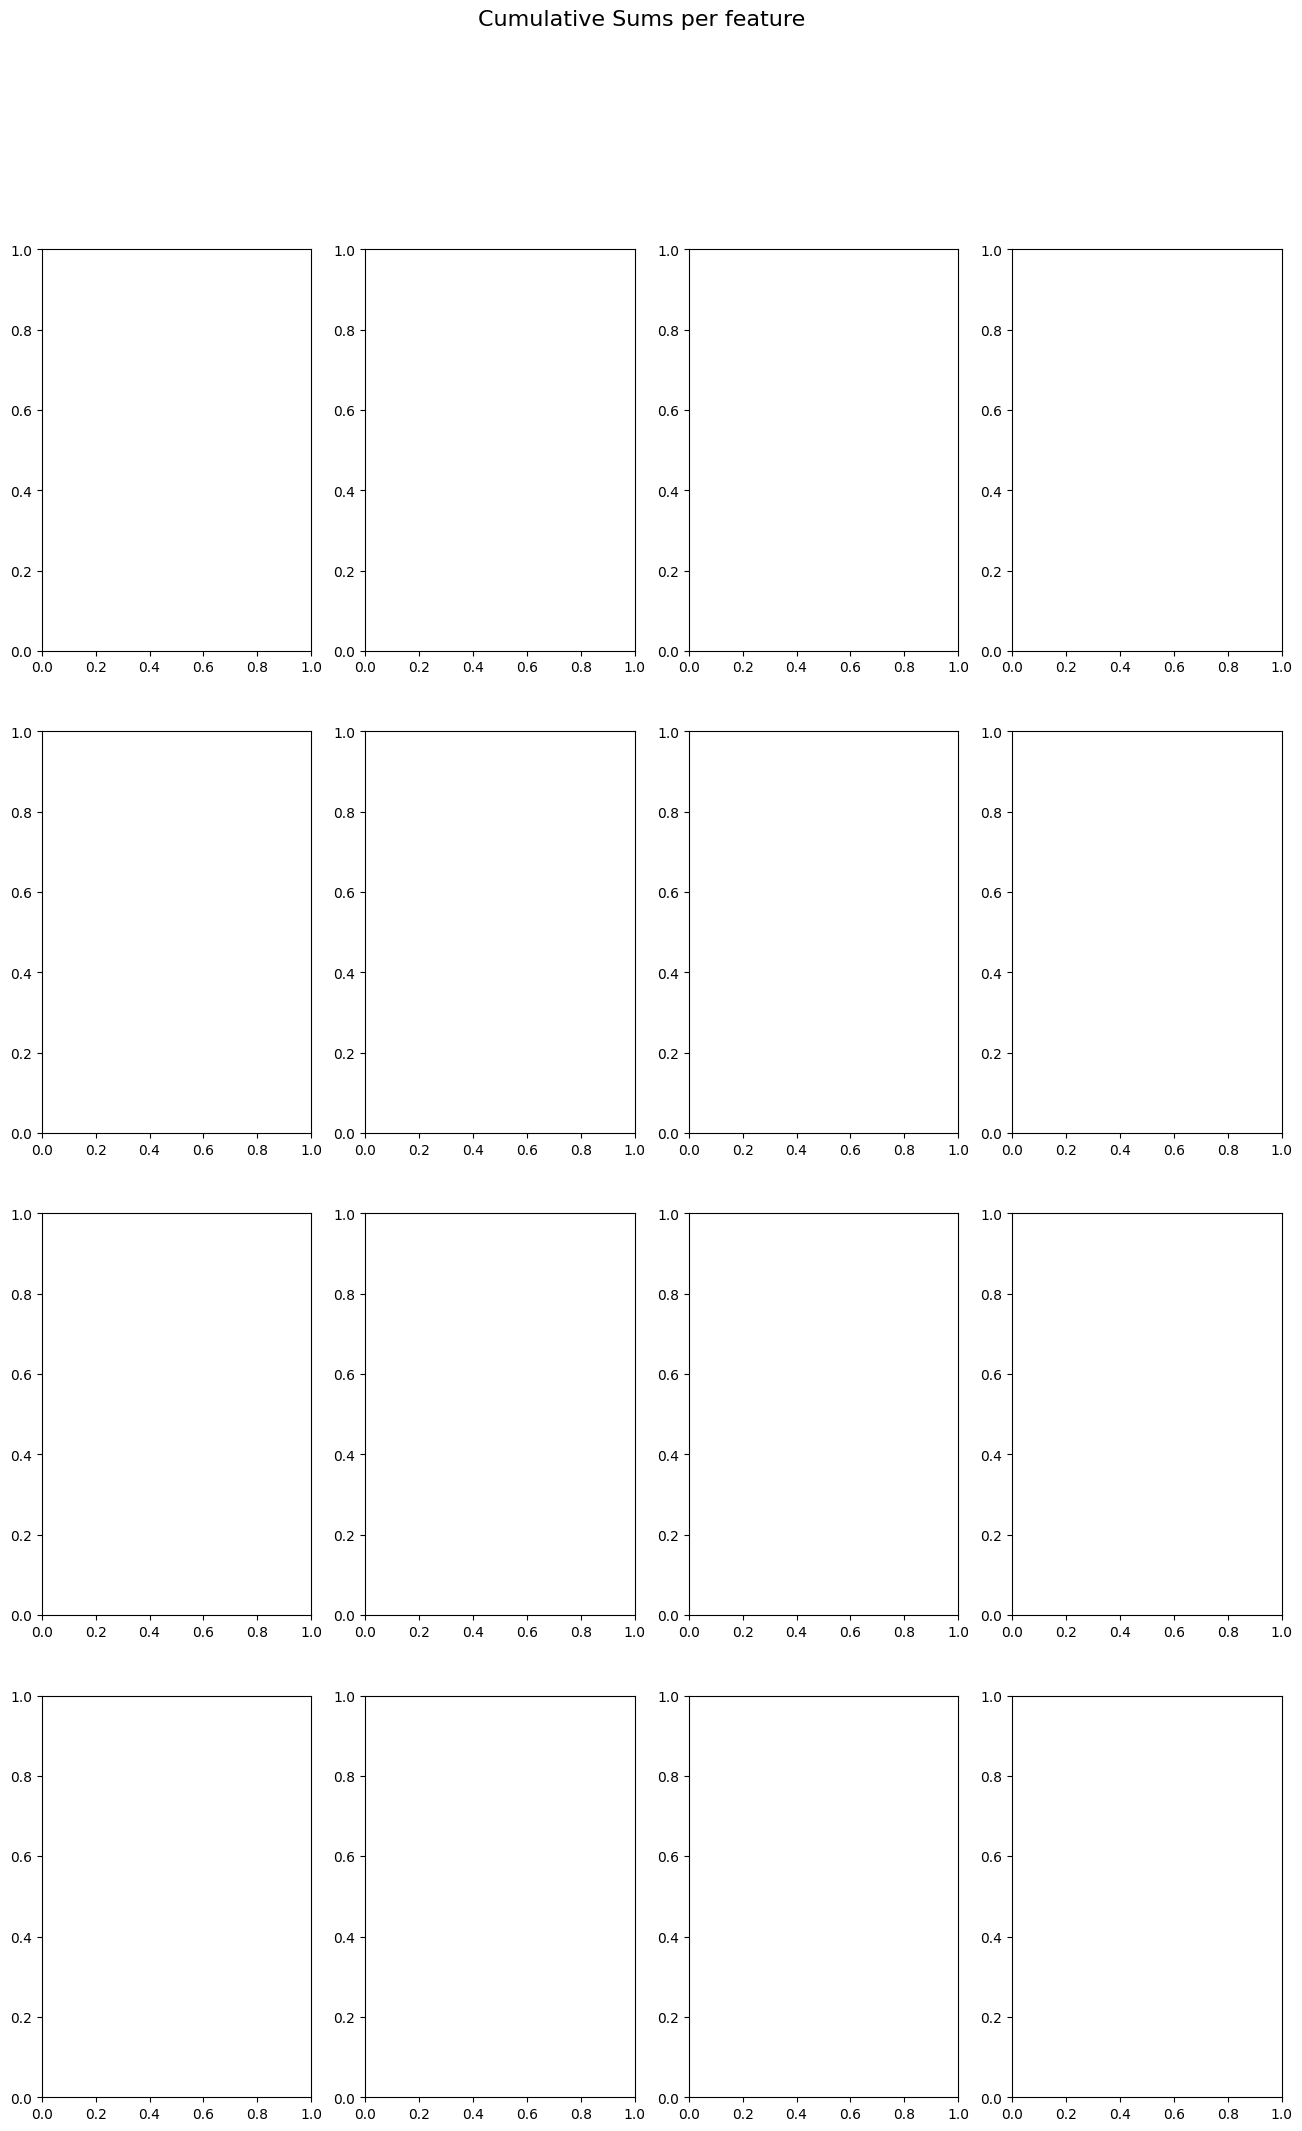

In [ ]:
!pip install table-evaluator

import pandas as pd
from table_evaluator import TableEvaluator

# Load your datasets
real_data = pd.read_csv('heart.csv')
synthetic_data = pd.read_csv('synthetic_data_vae.csv')

# Check the target column values to ensure they are discrete
print(real_data['target'].unique())

# Convert target column to integer if it isn't already
real_data['target'] = real_data['target'].astype(int)
synthetic_data['target'] = synthetic_data['target'].astype(int)

# Initialize the TableEvaluator
table_evaluator = TableEvaluator(real_data, synthetic_data)

# Generate visual evaluations (PCA plots, distributions, correlations, etc.)
table_evaluator.visual_evaluation()

# Get a full evaluation report with the correct target column
table_evaluator.evaluate(target_col='target')



In [ ]:
import pandas as pd
from table_evaluator import TableEvaluator

# Load your datasets
real_data = pd.read_csv('heart.csv')
synthetic_data = pd.read_csv('synthetic_data_diffusion.csv')

# Check the target column values to ensure they are discrete
print(real_data['target'].unique())

# Convert target column to integer if it isn't already
real_data['target'] = real_data['target'].astype(int)
synthetic_data['target'] = synthetic_data['target'].astype(int)

# Initialize the TableEvaluator
table_evaluator = TableEvaluator(real_data, synthetic_data)

# Generate visual evaluations (PCA plots, distributions, correlations, etc.)
table_evaluator.visual_evaluation()

# Get a full evaluation report with the correct target column
table_evaluator.evaluate(target_col='target')

ModuleNotFoundError: No module named 'table_evaluator'

[0 1]


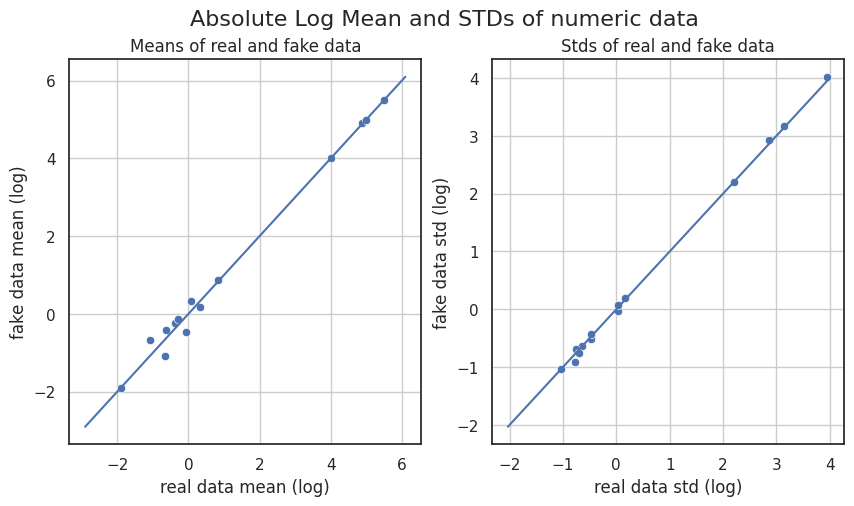

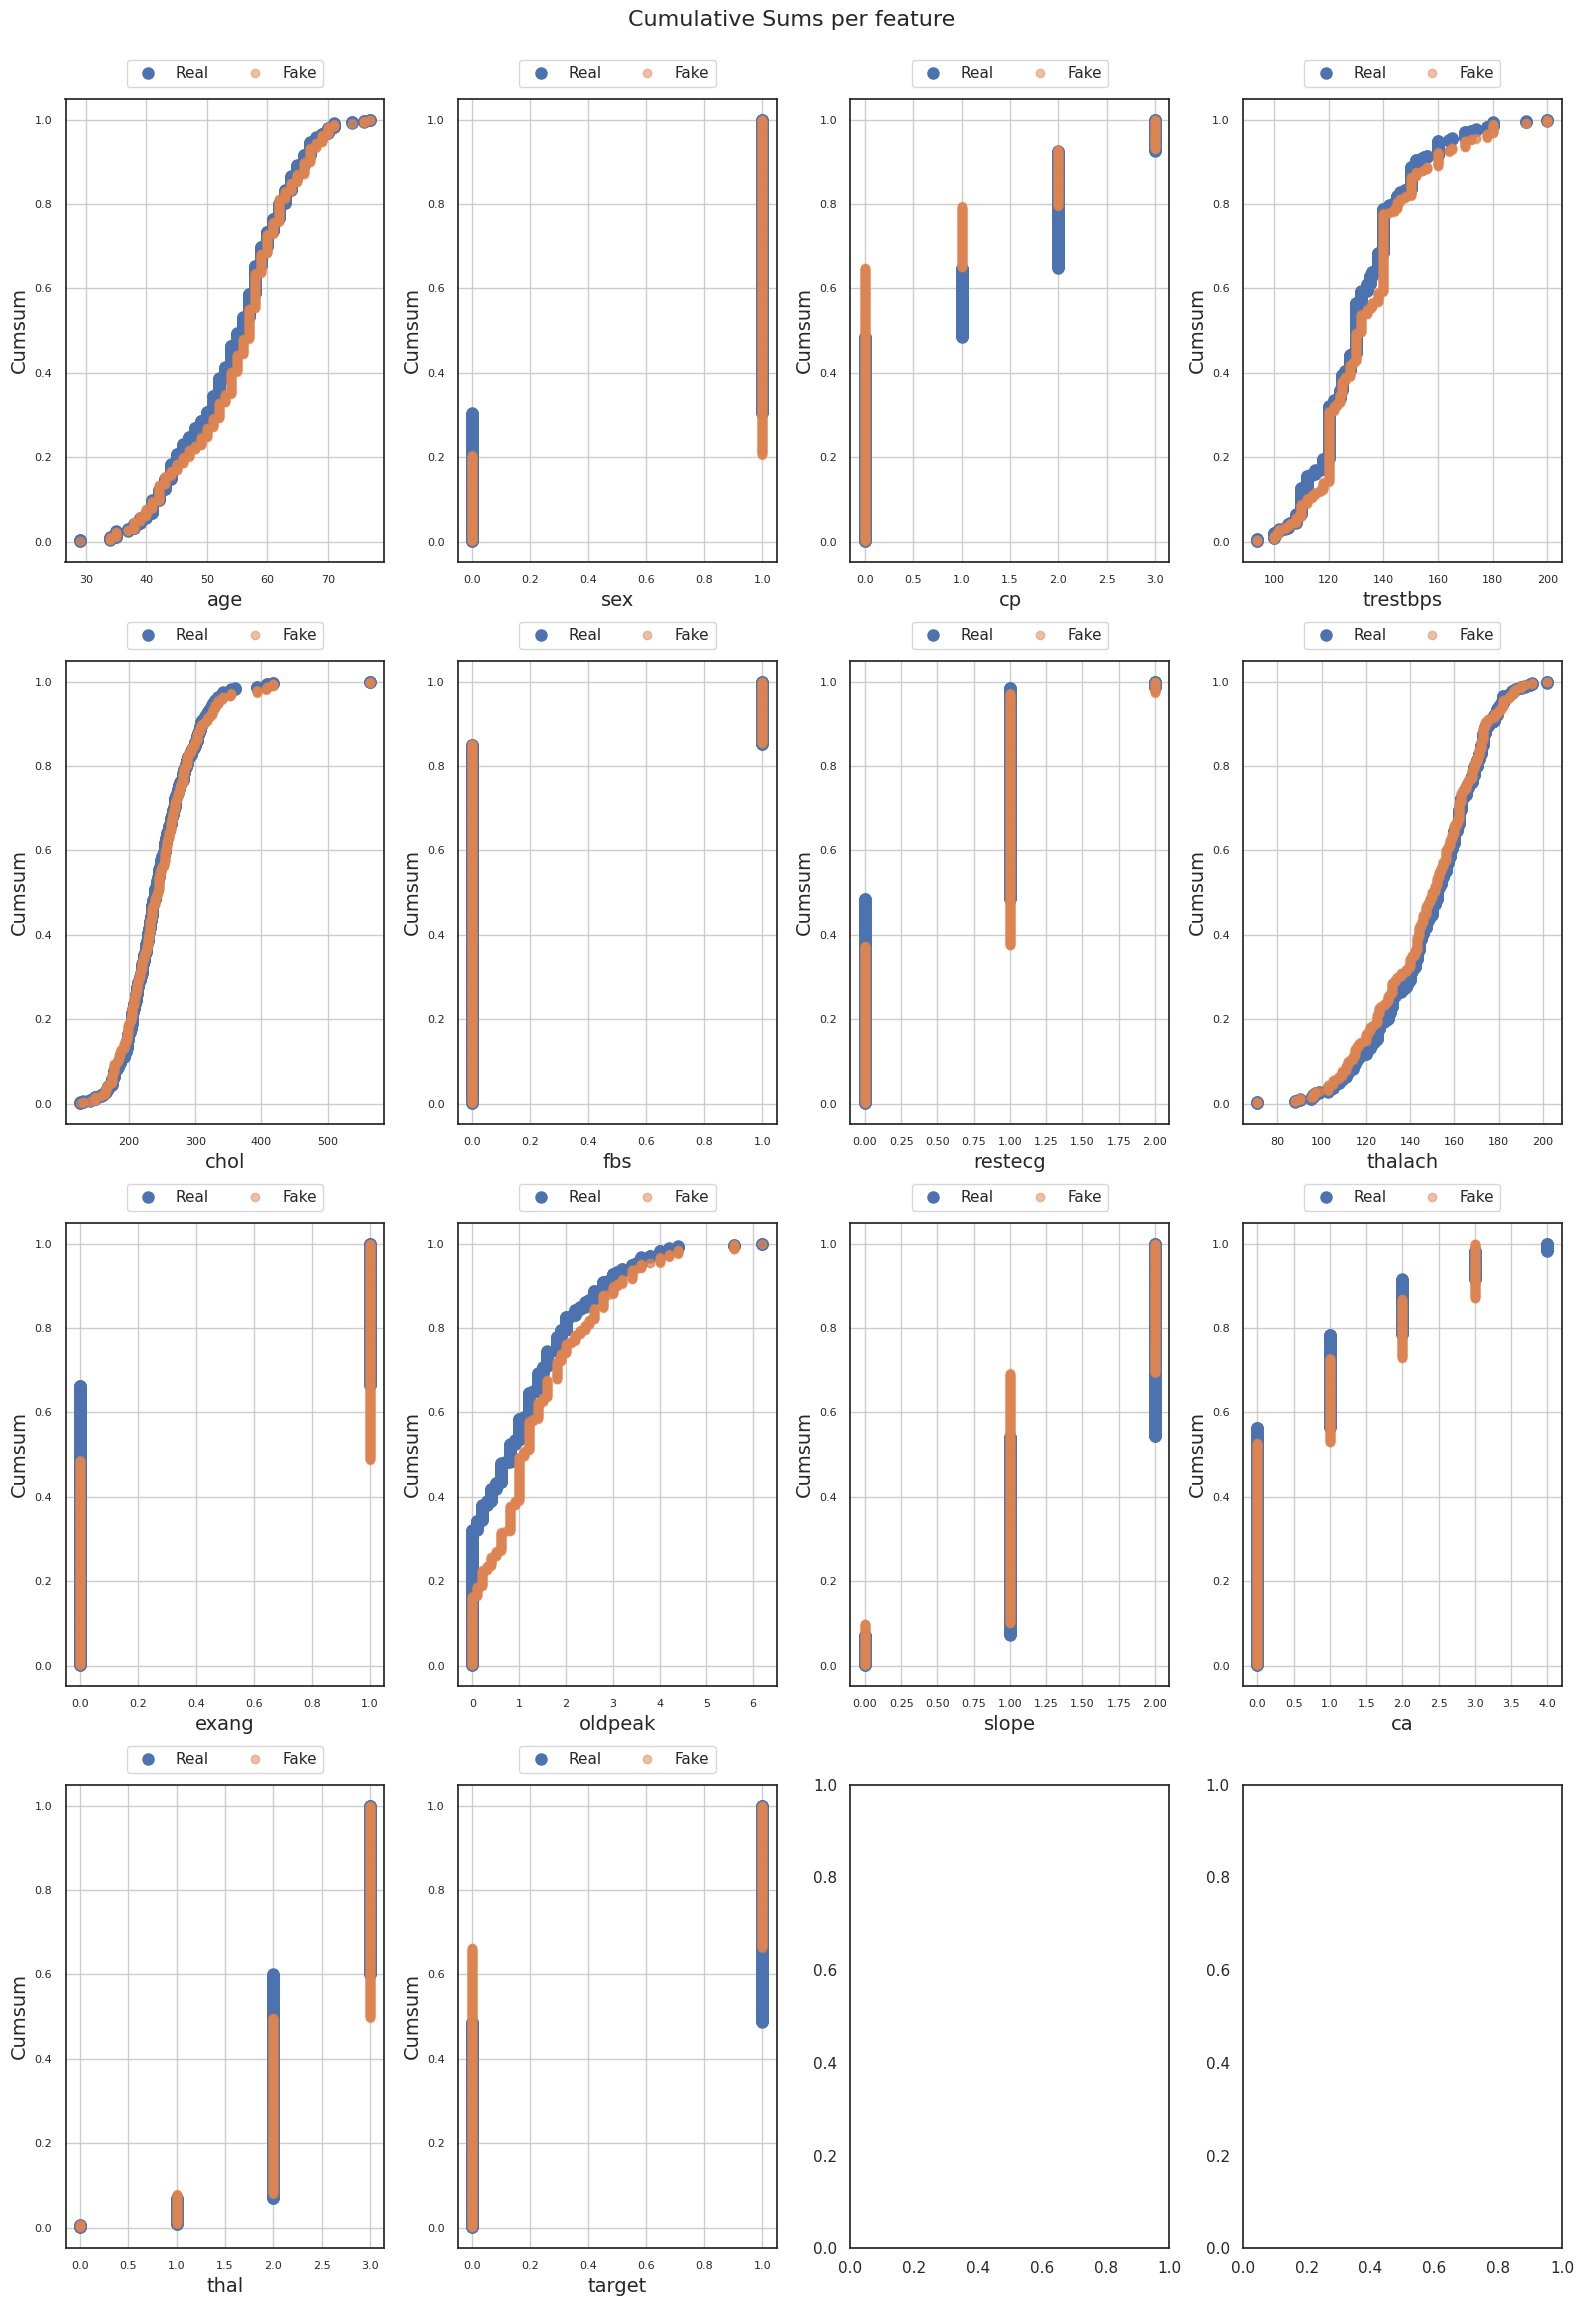

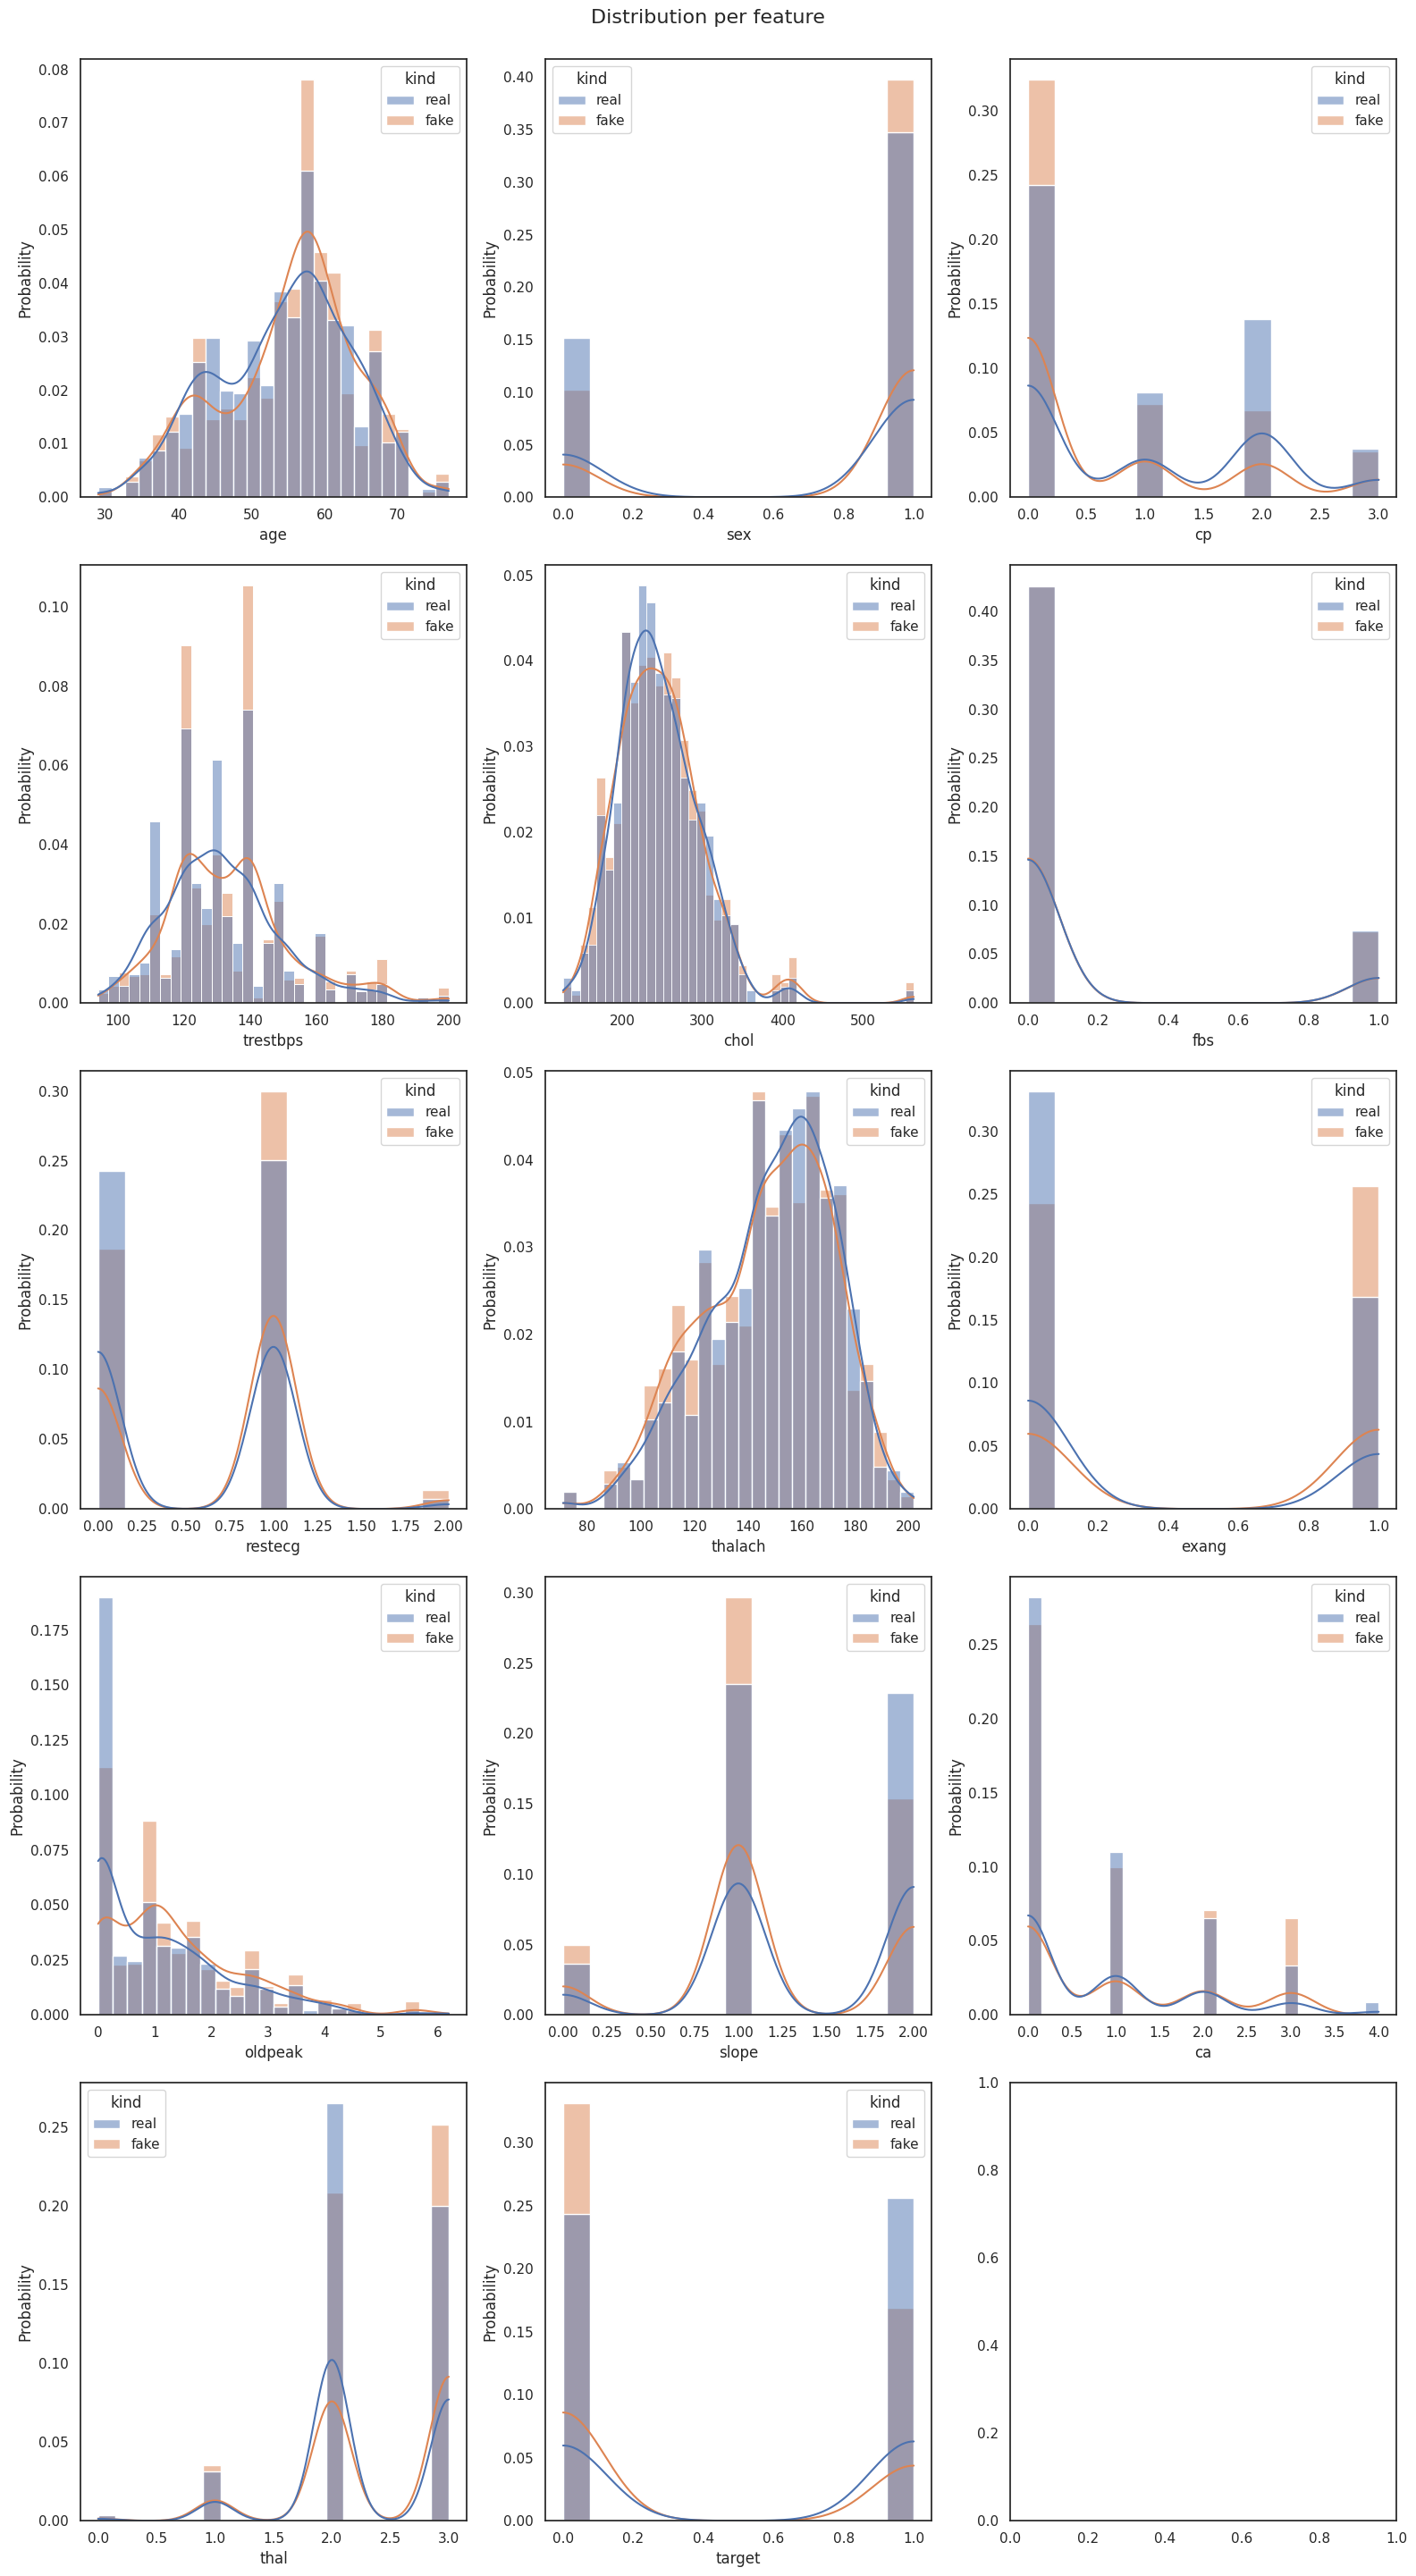

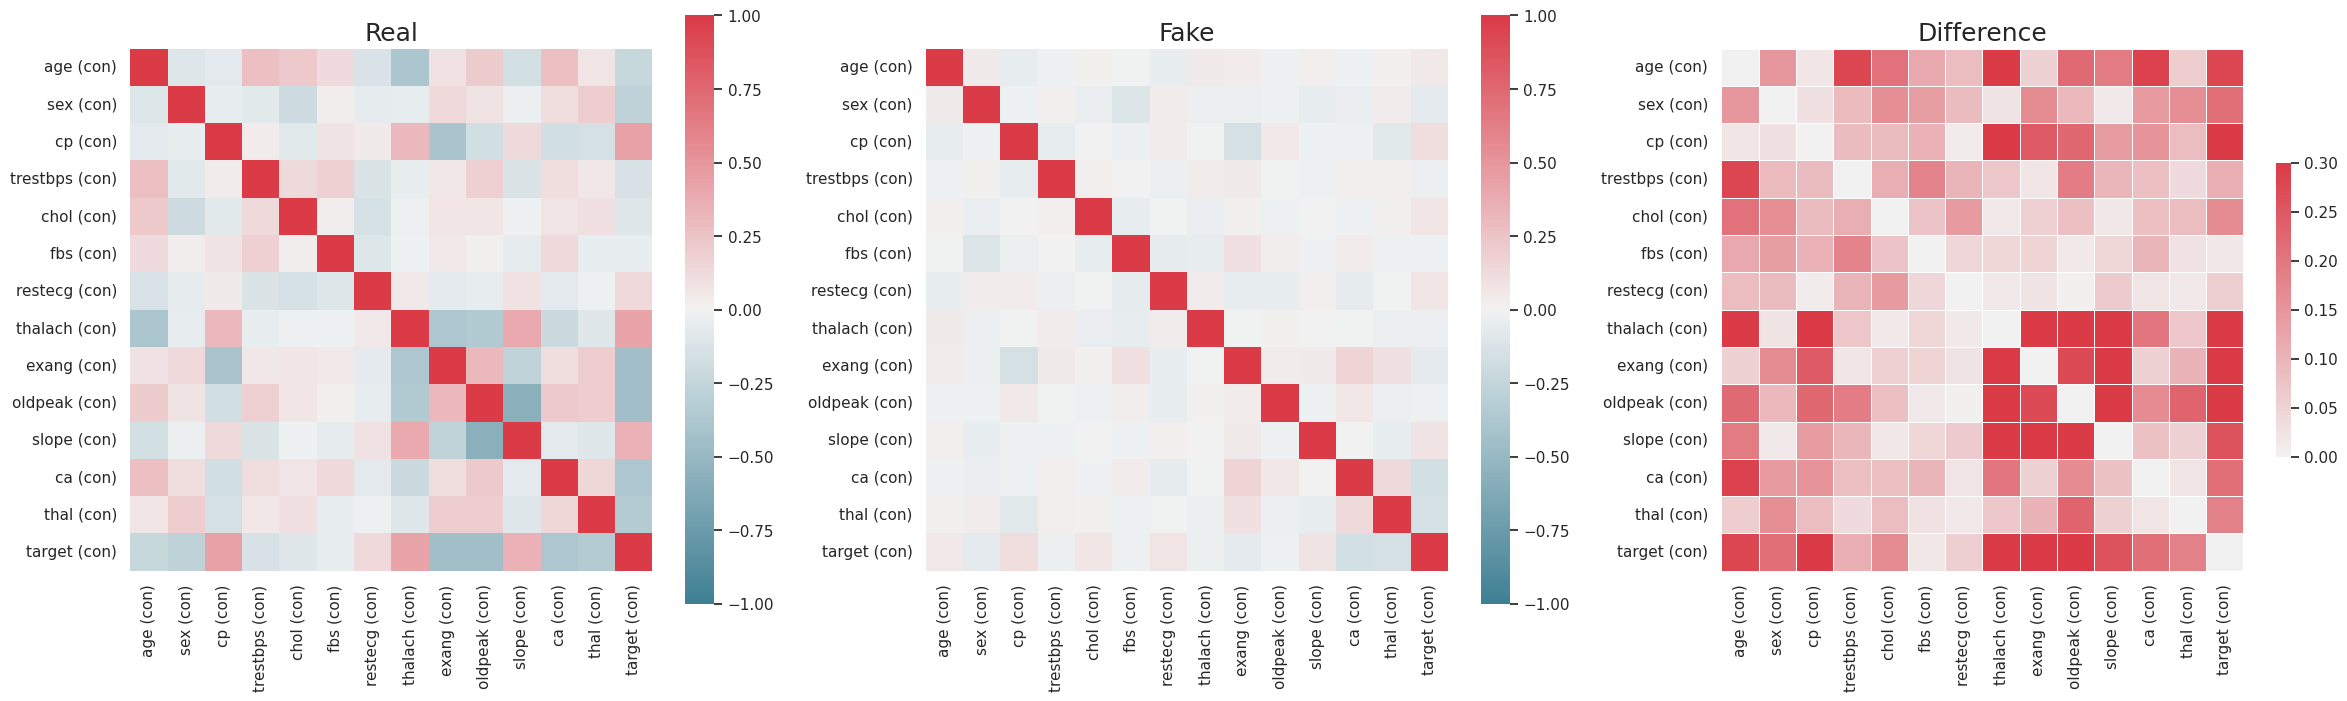

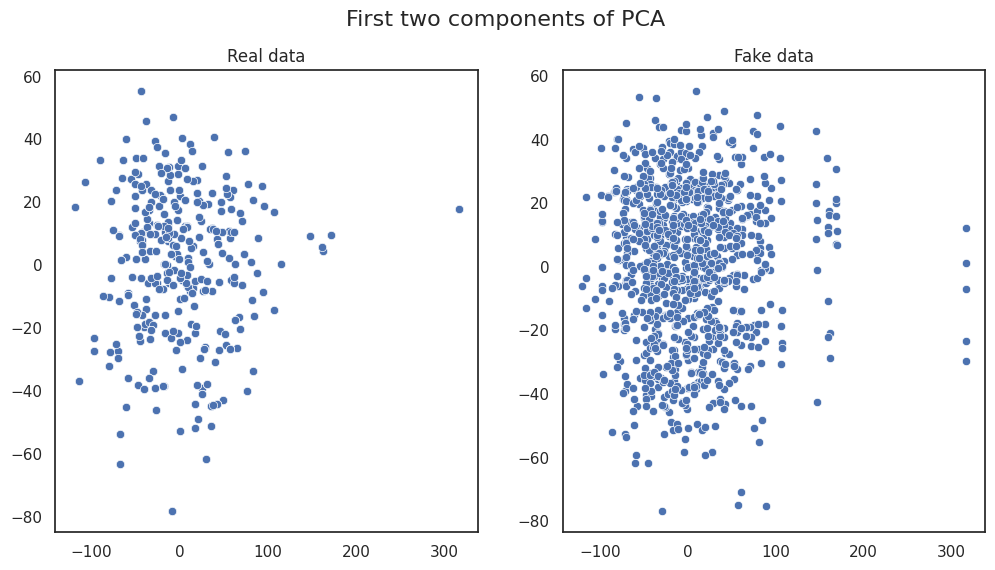

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.6293   0.5805              0.4591
DecisionTreeClassifier_real   1.0000   0.4878              0.3226
LogisticRegression_fake       0.6683   0.7024              0.6270
LogisticRegression_real       0.8390   0.5805              0.3851
MLPClassifier_fake            0.6488   0.6585              0.6466
MLPClassifier_real            0.8000   0.4878              0.3993
RandomForestClassifier_fake   0.6537   0.6829              0.5242
RandomForestClassifier_real   1.0000   0.4878              0.3226

Privacy results:
                                            result
Duplicate rows between sets (real/fake)  (1025, 0)
nearest neighbor mean                       1.9579
nearest neighbor std                        0.4822

Miscellaneous results:
                                  Resul

In [ ]:
import pandas as pd
from table_evaluator import TableEvaluator

# Load your datasets
real_data = pd.read_csv('heart.csv')
synthetic_data = pd.read_csv('synthetic_data_ctgan.csv')

# Check the target column values to ensure they are discrete
print(real_data['target'].unique())

# Convert target column to integer if it isn't already
real_data['target'] = real_data['target'].astype(int)
synthetic_data['target'] = synthetic_data['target'].astype(int)

# Initialize the TableEvaluator
table_evaluator = TableEvaluator(real_data, synthetic_data)

# Generate visual evaluations (PCA plots, distributions, correlations, etc.)
table_evaluator.visual_evaluation()

# Get a full evaluation report with the correct target column
table_evaluator.evaluate(target_col='target')